<h6><center>Wikipedia Articles Clustering & Classification Challenge</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Part 2 : Wikipedia articles classification</center>
<hr style=" border:none; height:3px;">
</h1>

__Author__: Alassane Watt -- github.com/tawlas

# Table of Content


* [Importing packages](#imp)
* [Helper functions](#hf)
* [Loading data](#ld)
* [Data Preprocessing](#pre)
* [Multi-Classification models](#ml)
    * [Spliting the data: train and test](#sp)
    * [Models](#m)
* [Comparison of model performance](#sum)
* [Model Evaluation](#ev)
    * [Precision, Recall, F1-score](#f1)
    * [Confusion Matrix](#cm)
* [Model deployment](#md)

<a id='imp'></a>
## Importing packages

In [1]:
from IPython.core.display import display, HTML 
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
from io import StringIO
from collections import Counter
import matplotlib.pyplot as plt
import re
import copy
from nltk.corpus import stopwords #assuming nltk is already installed
from nltk import PorterStemmer, WordNetLemmatizer
import datetime
import random
import string
import statistics as ss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

<a id='hf'></a>
## Helper functions

In [2]:
from utils.preprocessing import remove_duplicate_articles, preprocess_articles

<a id='ld'></a>
## Loading data

In [3]:
# articles data
articles_path = os.path.join("..", "data", "source", "dataset_business_technology_cybersecurity.pickle")
with open(articles_path, 'rb') as f:
    articles = pickle.load(f)
    
print("Nb of articles loaded:", len(articles))

# stopwords
stopwords_path = os.path.join("..", "data", "source", "stopwords.txt")
with open(stopwords_path) as f:
    stopwords = [word.strip() for word in f.readlines()]

print("Stop words size:", len(stopwords))

Nb of articles loaded: 333
Stop words size: 1313


<a id='pre'></a>
## Data Preprocessing

In [4]:
# Let's remove the duplicates articles.
articles = remove_duplicate_articles(articles)

In [5]:
# We are preprocessing the articles the same way we did in the Graph clustering notebook
articles = preprocess_articles(articles, stopwords, summary=False, title=True)

In [6]:
# creating a pandas dataframe
titles = [article['title'] for article in articles]
contents = [article['content'] for article in articles]
texts = [article['text'] for article in articles]
topics = [article['topic'] for article in articles]
articles_df = pd.DataFrame(index=range(len(texts)),columns=['title', 'content', 'text', 'topic'])
articles_df['title'] = titles
articles_df['content'] = contents
articles_df['text'] = [" ".join(text) for text in texts]
articles_df['topic'] = topics

articles_df.head()

,title,content,text,topic
0,Accounting,"<p class=""mw-empty-elt"">\n</p>\n\n<p><b>Accoun...",accounting accounting accountancy measurement ...,business
1,Commerce,<p><b>Commerce</b> is the exchange of goods an...,commerce commerce exchange services scale etym...,business
2,Finance,<p><b>Finance</b> is a term for matters regard...,finance finance term matters management creati...,business
3,Industrial relations,<p><b>Industrial relations</b> or <b>employmen...,industrial relations industrial relations empl...,business
4,Management,<p><b>Management</b> (or <b>managing</b>) is t...,management management managing administration ...,business


On top of the preprocessing made in Part 1: Graph clustering. We are adding a stemming step as part of our preprocessing.

In [7]:
def stemming(text):
    """ Applyin stemming to each word of the given article text """
    return(" ".join([PorterStemmer().stem(w) for w in text.split()]))

# apply stemming to each article
articles_df['text'] = articles_df['text'].apply(lambda x: stemming(x))
articles_df.head()

,title,content,text,topic
0,Accounting,"<p class=""mw-empty-elt"">\n</p>\n\n<p><b>Accoun...",account account account measur process commun ...,business
1,Commerce,<p><b>Commerce</b> is the exchange of goods an...,commerc commerc exchang servic scale etymolog ...,business
2,Finance,<p><b>Finance</b> is a term for matters regard...,financ financ term matter manag creation studi...,business
3,Industrial relations,<p><b>Industrial relations</b> or <b>employmen...,industri relat industri relat employ relat mul...,business
4,Management,<p><b>Management</b> (or <b>managing</b>) is t...,manag manag manag administr organ busi profit ...,business


In [8]:
# Create a new column 'topic_id' with encoded topic 
articles_df['topic_id'] = articles_df['topic'].factorize()[0]
topic_id_df = articles_df[['topic', 'topic_id']].drop_duplicates()


# Dictionaries for future use
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'topic']].values)

articles_df.head()

,title,content,text,topic,topic_id
0,Accounting,"<p class=""mw-empty-elt"">\n</p>\n\n<p><b>Accoun...",account account account measur process commun ...,business,0
1,Commerce,<p><b>Commerce</b> is the exchange of goods an...,commerc commerc exchang servic scale etymolog ...,business,0
2,Finance,<p><b>Finance</b> is a term for matters regard...,financ financ term matter manag creation studi...,business,0
3,Industrial relations,<p><b>Industrial relations</b> or <b>employmen...,industri relat industri relat employ relat mul...,business,0
4,Management,<p><b>Management</b> (or <b>managing</b>) is t...,manag manag manag administr organ busi profit ...,business,0


Let's recall our previous topic statistics

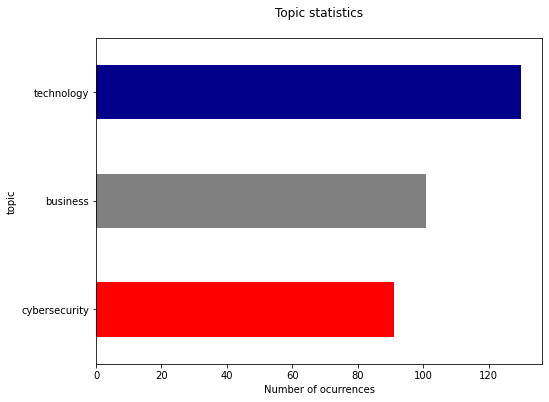

In [9]:
fig = plt.figure(figsize=(8,6))
colors = ['red','grey','darkblue']
articles_df.groupby('topic').text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Topic statistics\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [10]:
# We instantiate tfidf vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each text into a vector
features = tfidf.fit_transform(articles_df['text']).toarray()
labels = articles_df['topic_id']

print("Each of the %d article text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 322 article text is represented by 10084 features (TF-IDF score of unigrams and bigrams)


In [20]:
# Finding the three most correlated terms with each of the topic
N = 3
for topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(topic))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> business:
  * Most Correlated Unigrams are: economist, econom, busi
  * Most Correlated Bigrams are: busi busi, competit advantag, product servic

==> cybersecurity:
  * Most Correlated Unigrams are: vulner, secur, attack
  * Most Correlated Bigrams are: hole punch, secur vulner, access control

==> technology:
  * Most Correlated Unigrams are: secur, rail, electr
  * Most Correlated Bigrams are: engin design, electr engin, electr power


<a id='ml'></a>
## Multi-Classification models

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [21]:
X = articles_df['text'] # Collection of articles
y = articles_df['topic'] # Topics we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

Above all, a customer would not want Leo to suggest him or her an article that does not belong to his or her topic of interest. We want to ensure that whenever we classify an article as belonging in a topic, it really is true. In other words, we want to maximize the precision of our classification. For that we do a cross validation and select the model with the best precision score.

In [22]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
precision_scorer = make_scorer(lambda y_true,y_pred: precision_score(y_true, y_pred, average='micro'))
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    precisions = cross_val_score(model, features, labels, scoring=precision_scorer, cv=CV)
    for fold_idx, precision in enumerate(precisions):
        entries.append((model_name, fold_idx, precision))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'precision'])



RandomForestClassifier
LinearSVC
MultinomialNB
LogisticRegression


<a id='sum'></a>
## Comparison of model performance

The best mean precision was obtained with LinearSVC.

In [23]:
mean_precision = cv_df.groupby('model_name').precision.mean()
std_precision = cv_df.groupby('model_name').precision.std()

pre = pd.concat([mean_precision, std_precision], axis= 1, 
          ignore_index=True)
pre.columns = ['Mean precision', 'Standard deviation']
pre

,Mean precision,Standard deviation
model_name,,
LinearSVC,0.928654,0.027914
LogisticRegression,0.913221,0.053895
MultinomialNB,0.910096,0.055947
RandomForestClassifier,0.869663,0.040176


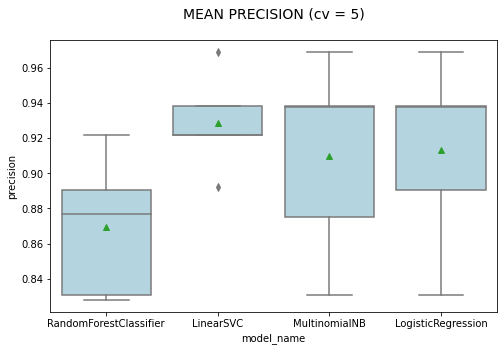

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='precision', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN PRECISION (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [25]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               articles_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id='f1'></a>
### Precision, Recall, F1-score

In [26]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= articles_df['topic'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

     business       0.92      1.00      0.96        24
   technology       0.97      0.94      0.95        33
cybersecurity       1.00      0.96      0.98        24

     accuracy                           0.96        81
    macro avg       0.96      0.97      0.96        81
 weighted avg       0.96      0.96      0.96        81



The class that can be classified with more precision is __‘Cybersecurity’__ with a precision of 1 which is extremely good. On average the precision of our model is 96%. It is relatively good, but more fine tuning would probably allow us to achieve better results. For reasons of time constaints, we were not able to play a lot more even though we implemented a cross validation method. 
The other scores are also quite good as we achieve an average of 96% on recall as well as f1-score.

<a id='cm'></a>
### Confusion Matrix

If we had a perfect model that always classifies correctly an article, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

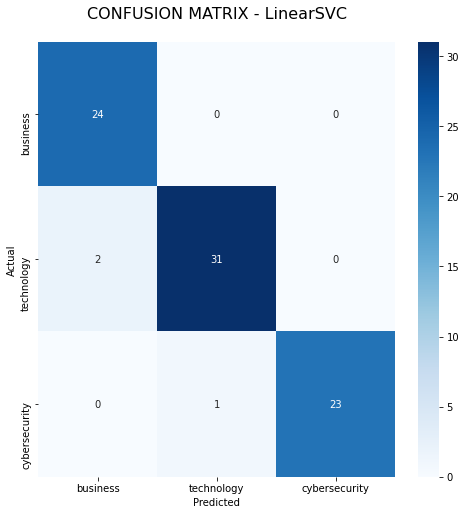

In [27]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=topic_id_df.topic.values, 
            yticklabels=topic_id_df.topic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

The confusion matrix looks pretty good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the article was classified in a wrong class.

#### Misclassified articles
Let’s have a look at the cases that were wrongly classified.

In [28]:
for predicted in topic_id_df.topic_id:
    for actual in topic_id_df.topic_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_topic[actual], 
                                                           id_to_topic[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(articles_df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['topic', 
                                                                'content']])
            print('')

'technology' predicted as 'business' : 2 examples.


,topic,content
120,technology,<p>A <b>public utility company</b> (usually ju...
180,technology,<p><b>Electricity retailing</b> is the final s...



'cybersecurity' predicted as 'technology' : 1 examples.


,topic,content
272,cybersecurity,<p><b>Trojan</b> or <b>Trojans</b> may refer t...


#### Most correlated terms with each topic

In [29]:
model.fit(features, labels)

N = 4
for topic, topic_id in sorted(topic_to_id.items()):
    indices = np.argsort(model.coef_[topic_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(topic))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'business':
  * Top unigrams: busi, econom, corpor, organiz
  * Top bigrams: chang manag, organiz chang, product servic, busi model

==> 'cybersecurity':
  * Top unigrams: secur, attack, vulner, firewal
  * Top bigrams: access control, secur oper, secur design, oper secur

==> 'technology':
  * Top unigrams: engin, electr, machin, autom
  * Top bigrams: electron devic, assembl languag, civil engin, engin design


<a id='md'></a>
## Model deployment

First, I would clearly spell out what constitutes good and bad performance.
Then, I will see the constraints (computation time and space, scalability, robustness, etc...) that we face to choose the best model to put into production.